In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import sys
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from help_functions import create_model, get_top_classes, plot_distribution

### Select the training configuration

In [16]:
training_setup = 0

with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(training_setup)]

old_stdout = sys.stdout
log_file = open(config['results_and_checkpoints_folder'] + '/log.txt', 'w')
sys.stdout = log_file

In [17]:
config

{'nr_classes': 20,
 'class_weights': False,
 'augment': False,
 'basemodel': 'EfficientNetB2',
 'image_dimension': 64,
 'results_and_checkpoints_folder': 'train/0_algo_Falseaugment_20classes_Falseweights_EfficientNetB2',
 'data_folder': 'data/split_dataframes_heuristic_labels_20220914'}

### Plot training metrics

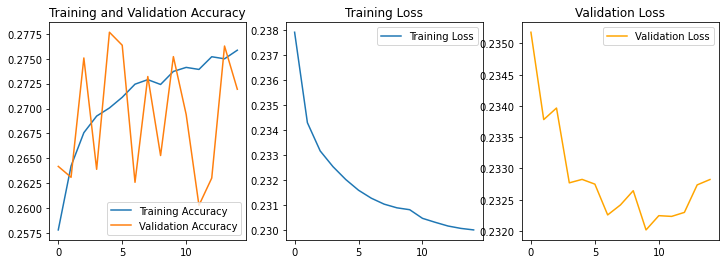

In [35]:
# Plot training metrics: loss & accuracy
training_metrics = pd.read_csv(config['results_and_checkpoints_folder'] + '/history.csv')

epochs = training_metrics.shape[0]

acc = training_metrics.accuracy.values
loss = training_metrics.loss.values

val_acc = training_metrics.val_accuracy.values
val_loss = training_metrics.val_loss.values

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1, 3, 3)
plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.savefig(config['results_and_checkpoints_folder'] + '/training_metrics.png')
plt.show()

Load test set

Found 760000 non-validated image filenames belonging to 42 classes.
Classes with most images:['Places' 'Society' 'Culture' 'People' 'Objects' 'History' 'Nature'
 'Events' 'Politics' 'Technology' 'Sports' 'Entertainment' 'Art'
 'Language' 'Architecture' 'Plants' 'Science' 'Music' 'Biology'
 'Landscapes']


<ipython-input-5-3fcf83a0c715>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 39614 non-validated image filenames belonging to 20 classes.
Found 39614 validated image filenames belonging to 20 classes.


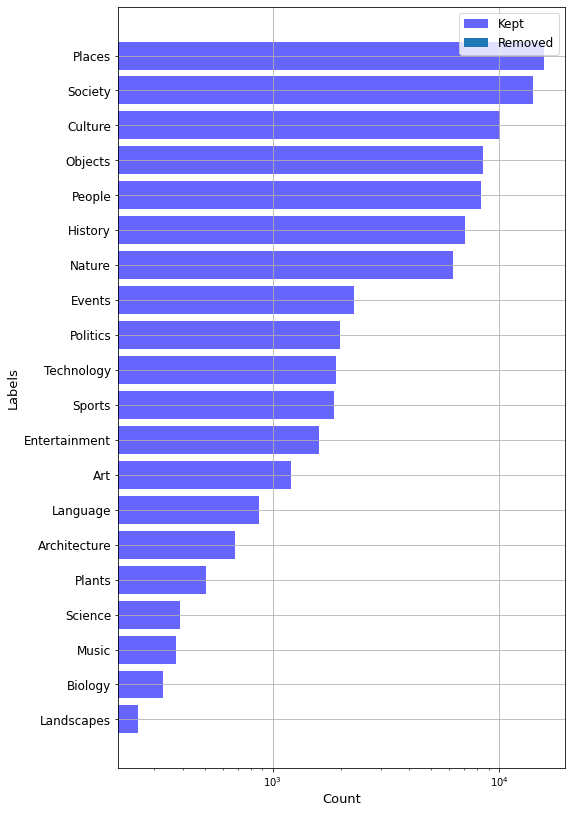

In [5]:
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')
train_df = pd.read_json(config['data_folder'] + '/train_df.json.bz2', compression='bz2')
top_classes = get_top_classes(config['nr_classes'], train_df) # OBS: are they always the same as top classes of train_df? In the 10-case yes.
print('Classes with most images:' + str(top_classes))
# Only keep rows which have either of the top classes
ids_x_labels = test_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
test_set_x_labels = test_df[ids_x_labels]
test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
test_df = test_set_x_labels.copy()

plot_distribution(dataframe=test_df, filename=config['data_folder'] + '/test_distribution.png')

datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(config['image_dimension'], config['image_dimension']),
        shuffle=False
        )

N_LABELS = len(test.class_indices)

Create model and load latest weights

In [6]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model(name):
    if name == 'EfficientNetB0':
        efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(config['image_dimension'], config['image_dimension'], 3))
    elif name == 'EfficientNetB1':
        efficient_net = EfficientNetB1(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(config['image_dimension'], config['image_dimension'], 3))
    elif name == 'EfficientNetB2':
        efficient_net = EfficientNetB2(include_top=False, weights='imagenet', classes=config['nr_classes'],
                                           input_shape=(config['image_dimension'], config['image_dimension'], 3))

    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(config['nr_classes'], activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy'])

    model.summary()
    return model
model = create_model(name=config['basemodel'])
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
#     show_shapes=True,
#     show_layer_names=True
# )

latest = tf.train.latest_checkpoint(config['results_and_checkpoints_folder'])
print(latest)
model.load_weights(latest)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               721024    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 723,604
Non-trainable params: 7,768,569
_________________________________________________________________
train/0_algo_Falseaugment_20classes_Falseweights_EfficientNetB2/cp-0015.ckpt


Predict on test set

In [7]:
from sklearn.metrics import classification_report

predictions = model.predict(test, verbose=1)

1238/1238 [==============================] - 672s 543ms/step


In [8]:
threshold = 0.5
y_pred = 1 * (predictions > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

In [9]:
y_true.shape
predictions.shape

(39614, 20)

In [10]:
np.savetxt(config['results_and_checkpoints_folder'] + '/y_pred.csv', y_pred, delimiter=",")
np.savetxt(config['results_and_checkpoints_folder'] + '/y_true.csv', y_true, delimiter=",")

In [12]:
from sklearn.metrics import multilabel_confusion_matrix

confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

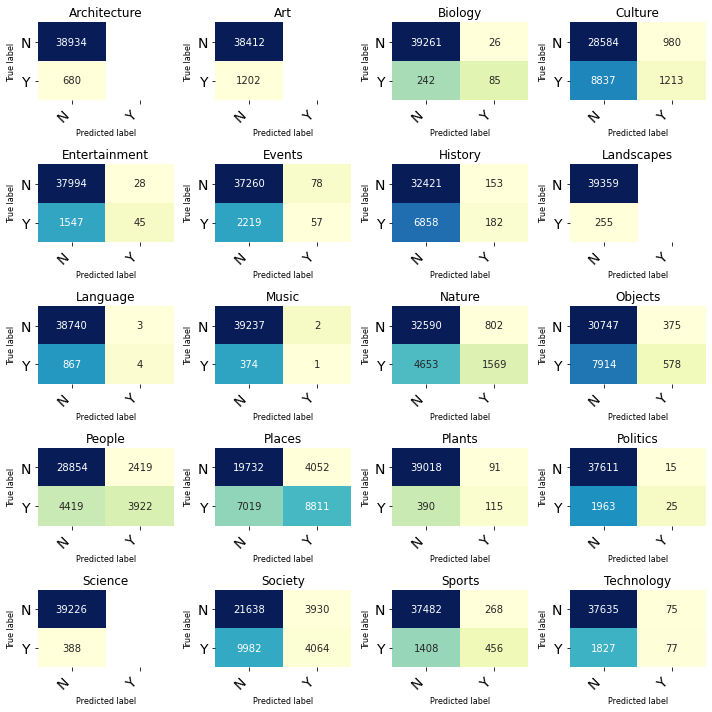

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """From https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python"""
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='YlGnBu', norm=LogNorm())
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label', fontsize=8)
    axes.set_xlabel('Predicted label', fontsize=8)
    axes.set_title(class_label)
fig, ax = plt.subplots(5, 4, figsize=(10, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, list(test.class_indices.keys())):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.savefig(config['results_and_checkpoints_folder'] + '/confusion_matrix.png')
plt.show()

##### Mean number of assignments per image in the ground-truth. 

We expect this value to be greater than the one in the predictions since the basemodel in which the network is trained (ImageNet) predicts a single label per image.

In [18]:
print(f'Mean number of label assignments per image in ground-truth: {np.sum(y_true) / y_true.shape[0]:.4f}')
print(f'Mean number of label assignments per image in predictions: {np.sum(y_pred) / y_pred.shape[0]:.4f}')

In [23]:
a = np.array([0,1,2,3,4,5,6,7,8,9])

In [30]:
a[0:-4]

array([0, 1, 2, 3, 4, 5])

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score  support index
Architecture    0.000000  0.000000  0.000000    680.0     0
Art             0.000000  0.000000  0.000000   1202.0     1
Biology         0.765766  0.259939  0.388128    327.0     2
Culture         0.553124  0.120697  0.198154  10050.0     3
Entertainment   0.616438  0.028266  0.054054   1592.0     4
Events          0.422222  0.025044  0.047283   2276.0     5
History         0.543284  0.025852  0.049356   7040.0     6
Landscapes      0.000000  0.000000  0.000000    255.0     7
Language        0.571429  0.004592  0.009112    871.0     8
Music           0.333333  0.002667  0.005291    375.0     9
Nature          0.661746  0.252170  0.365181   6222.0    10
Objects         0.606506  0.068064  0.122393   8492.0    11
People          0.618514  0.470207  0.534260   8341.0    12
Places          0.684988  0.556601  0.614157  15830.0    13
Plants          0.558252  0.227723  0.323488    505.0    14
Politics        0.625000  0.012575  0.02

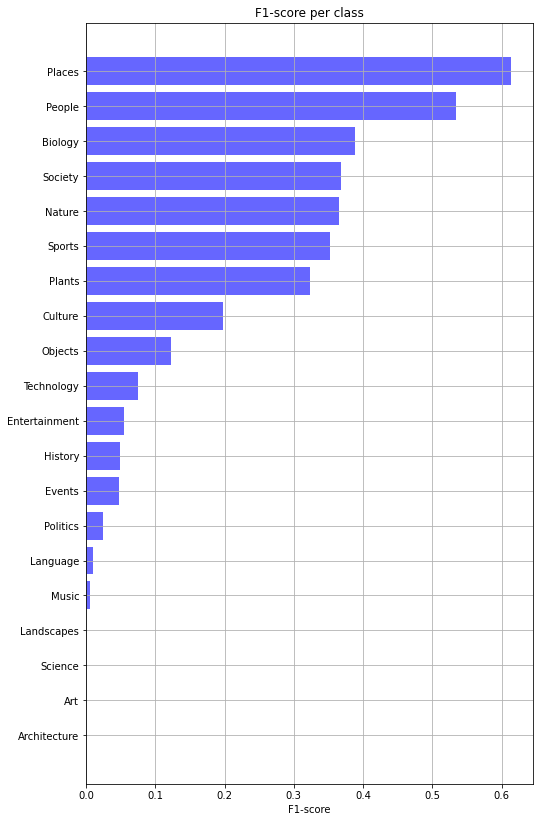


Per-class accuracy:

Architecture 0/680 == 0.0
Art 0/1202 == 0.0
Biology 85/327 == 0.26
Culture 1213/10050 == 0.121
Entertainment 45/1592 == 0.028
Events 57/2276 == 0.025
History 182/7040 == 0.026
Landscapes 0/255 == 0.0
Language 4/871 == 0.005
Music 1/375 == 0.003
Nature 1569/6222 == 0.252
Objects 578/8492 == 0.068
People 3922/8341 == 0.47
Places 8811/15830 == 0.557
Plants 115/505 == 0.228
Politics 25/1988 == 0.013
Science 0/388 == 0.0
Society 4064/14046 == 0.289
Sports 456/1864 == 0.245
Technology 77/1904 == 0.04


In [34]:
# ================== GET METRICS ======================

metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_LABELS), [None, None, None, None]))
print(metrics_df)
# logger.info(metrics_df)

# F1-score
sorted_indices_f1score = np.argsort(metrics_df['f1-score'][0:N_LABELS])
sorted_f1score_per_class = metrics_df['f1-score'][0:N_LABELS][sorted_indices_f1score]

# Comparison done just as in Lee et al. https://ieeexplore.ieee.org/document/7533053/ 
print(f'\nUnweighted average F1-score of top 5 classes: {np.sum(sorted_f1score_per_class[-4:]) / 5}')
print(f'Unweighted average F1-score of the rest: {np.sum(sorted_f1score_per_class[0:-4]) / (len(sorted_f1score_per_class) - 5)}')

_ = plt.figure(figsize=(8, 14))      
_ = plt.title('F1-score per class')
_ = plt.barh(range(y_true.shape[1]), sorted_f1score_per_class, color='blue', alpha=0.6)
_ = plt.yticks(ticks=range(N_LABELS), 
               labels=np.array(list(test.class_indices.keys()))[sorted_indices_f1score])
_ = plt.xlabel('F1-score')
_ = plt.grid(True)

plt.savefig(config['results_and_checkpoints_folder'] + '/f1_scores.png')
plt.show()

print('\nPer-class accuracy:\n')
# Per-class accuracy
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l] += 1
    predicted_y = np.argwhere(predictions[i] >= 0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]] += 1

name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k
            
for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
    # logger.info(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
# ======================================================


#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

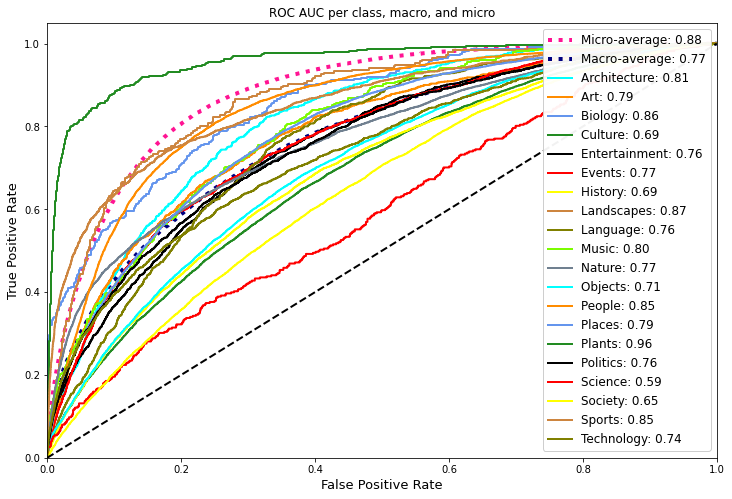

In [32]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_LABELS)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_LABELS):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_LABELS

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(12, 8))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"Micro-average: { roc_auc['micro'] :0.2f}",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"Macro-average: { roc_auc['macro'] :0.2f}",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
for i, color in zip(range(N_LABELS), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"{list(name_id_map.keys())[i]}: {roc_auc[i]:0.2f}"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC AUC per class, macro, and micro")
plt.legend(loc="best", fontsize=12, framealpha=0.95)
plt.savefig(config['results_and_checkpoints_folder'] + '/roc_curves.png')
plt.show()

In [33]:
sys.stdout = old_stdout

log_file.close()